In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
# add column converting size from bytes to megabytes
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/items&page=0 HTT

In [10]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,97.105.15.120,1,0.000072
10,34.207.64.242,1,0.000072
11,52.90.165.200,1,0.000072
12,35.174.209.2,1,0.000072
13,95.31.18.119,1,0.000072


22
               ip  ip_count  ip_proba
12   35.174.209.2         1  0.000072
13   95.31.18.119         1  0.000072
14   52.91.30.150         1  0.000072
15  54.172.14.223         1  0.000072
16   45.23.250.16         1  0.000072
17  54.145.52.184         1  0.000072
18   95.31.16.121         1  0.000072
19   3.92.201.136         1  0.000072
20   3.88.129.158         1  0.000072
21  34.229.70.250         1  0.000072


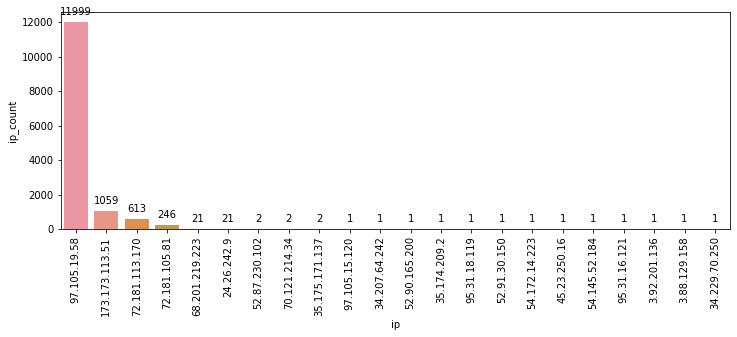

In [11]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [34]:
df = pd.read_csv('curriculum-access.txt', 
                    engine='python',
                    header=None,
                    index_col=False,
                    names = ['date', 'time', 'page', 'user', 'cohort_id', 'ip'],
                    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                    na_values='"-"')

In [35]:
df.head()

,date,time,page,user,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [36]:
df.shape

(543596, 6)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 6 columns):
date         543596 non-null object
time         543596 non-null object
page         543595 non-null object
user         543596 non-null int64
cohort_id    515740 non-null float64
ip           543596 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 24.9+ MB


In [38]:
df.dtypes

date          object
time          object
page          object
user           int64
cohort_id    float64
ip            object
dtype: object

In [39]:
# combine date and time together 
df['timestamp'] = df.date + ' ' + df.time
df = df.drop(columns = ['date', 'time'])
df.head()

,page,user,cohort_id,ip,timestamp
0,/,1,8.0,98.106.20.62,2018-01-26 09:55:03
1,java-ii,1,8.0,98.106.20.62,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,98.106.20.62,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,98.106.20.62,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,98.106.20.62,2018-01-26 09:56:24


In [40]:
df.timestamp = pd.to_datetime(df.timestamp)

In [41]:
df = df.set_index('timestamp').sort_values('timestamp')

In [42]:
df.head()

,page,user,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [43]:
df.tail()

,page,user,cohort_id,ip
timestamp,,,,
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17
2020-05-15 15:05:14,10-anomaly-detection/3-discrete-probabilistic-...,11,28.0,77.186.132.227
2020-05-15 15:06:05,examples/javascript/blog.json,643,57.0,174.175.131.39


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543596 entries, 2018-01-26 09:55:03 to 2020-05-15 15:06:05
Data columns (total 4 columns):
page         543595 non-null object
user         543596 non-null int64
cohort_id    515740 non-null float64
ip           543596 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 20.7+ MB


In [45]:
df.user.value_counts()

11     11065
64     10784
53      9534
1       5437
344     5370
       ...  
593        1
592        1
649        1
66         1
163        1
Name: user, Length: 650, dtype: int64

In [46]:
df.cohort_id.value_counts()

33.0    38851
28.0    37409
29.0    36613
24.0    35336
53.0    29992
22.0    28997
23.0    28193
32.0    27920
26.0    27586
51.0    26389
52.0    26212
25.0    25364
31.0    24322
34.0    23845
27.0    20264
56.0    14438
55.0    14252
57.0     9547
14.0     9374
1.0      8882
21.0     7411
17.0     4821
13.0     2626
8.0      1712
18.0     1641
19.0     1165
16.0      743
15.0      691
7.0       495
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
5.0         1
Name: cohort_id, dtype: int64

In [47]:
df['2020-05-7 00:47':'2020-05-7 23:49'].tail(50)

,page,user,cohort_id,ip
timestamp,,,,
2020-05-07 22:32:38,appendix,571,53.0,173.125.68.94
2020-05-07 22:36:30,java-i/console-io,614,56.0,175.237.4.4
2020-05-07 22:36:38,java-ii/object-oriented-programming,614,56.0,175.237.4.4
2020-05-07 22:38:25,search/search_index.json,614,56.0,175.237.4.4
2020-05-07 22:38:44,javascript-i/objects,633,57.0,25.27.243.225
2020-05-07 22:41:28,/,621,57.0,137.51.18.204
2020-05-07 22:41:32,javascript-i,621,57.0,137.51.18.204
2020-05-07 22:41:34,javascript-i/coffee-project,621,57.0,137.51.18.204
2020-05-07 22:42:56,java-i,648,56.0,77.188.54.88


In [48]:
df.groupby(["user", "cohort_id"]).count()

page    ip
user cohort_id            
1    8.0        1617  1617
     28.0       3820  3820
2    22.0       1541  1541
3    22.0       1562  1562
4    22.0        692   692
...              ...   ...
646  8.0          41    41
647  14.0         10    10
648  56.0        488   488
649  5.0           1     1
650  34.0          2     2

[628 rows x 2 columns]

In [49]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)

In [50]:
ip_df

,ip,ip_count,ip_proba
0,98.106.20.59,284579,0.523512
1,98.106.20.62,61662,0.113434
2,193.172.118.211,9029,0.016610
3,13.107.209.195,4219,0.007761
4,173.125.68.94,2980,0.005482
...,...,...,...
3490,98.78.228.132,1,0.000002
3491,108.78.229.137,1,0.000002
3492,97.28.162.214,1,0.000002
3493,100.204.156.79,1,0.000002


In [51]:
df.head()

,page,user,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [72]:
df[df.user == 591].tail(30)

,page,user,cohort_id,ip
timestamp,,,,
2020-05-06 10:56:29,8-clustering/project,591,55.0,174.176.101.202
2020-05-07 07:51:16,/,591,55.0,174.176.101.202
2020-05-07 07:51:22,8-clustering/project,591,55.0,174.176.101.202
2020-05-07 09:44:40,5-stats/4.2-compare-means,591,55.0,174.176.101.202
2020-05-07 10:02:13,5-stats/4.2-compare-means,591,55.0,174.176.101.202
2020-05-07 15:52:57,5-stats/4.5-more-statistical-testing-examples,591,55.0,174.176.101.202
2020-05-07 15:52:58,5-stats/Selecting_a_hypothesis_test.svg,591,55.0,174.176.101.202
2020-05-07 15:53:27,8-clustering/project,591,55.0,174.176.101.202
2020-05-07 16:37:22,/,591,55.0,174.176.101.202
